In [1]:
#Import Necessary Packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

After completing the exploratory data analysis along with statistical analysis in the last portion to answer high level questions about the different subgroups of data across boroughs and age groups, proportion of different groups, and change over time, we can begin to apply machine learning to the data.

We also determined the variables that were statistically significant with regards to their relationship with diversion and capture rates and their individual correlation in the heatmap. We will now move on to apply machine learning techniques to see how our variables together can be used to predict recycling rates and determine feature importance at a multivariate level.

Below we will begin by loading the dataframe from the csv and creating the filtered dataframe with the specified X and Y variables that were narrowed through correlation and p-value analysis.

In [2]:
%%capture

#Load in dataframes created in the Data Wrangling portion
df_2016 = pd.read_csv('recycling_districts_2016')

#Create list of all possible X-variables in dataframe, which are the columns that are NOT the rates
#Create list of all possible Y-variables in dataframe, which are the columns that ARE the rates
rec_x_variables = list(df_2016.columns[9:])
rec_y_rates = list(df_2016.columns[4:8])
del rec_y_rates[1:3]

#Create sublists of categories of variables - Economic, Community, Race, Age Groups
economic = ['poverty_rate', 'pct_bach_deg', 'unemployment_cd', 'mean_commute']
community = ['pct_hh_rent_burd', 'pct_clean_strts', 'count_public_schools', 'count_hosp_clinic']
race = ['pct_black_nh', 'pct_white_nh', 'pct_hispanic', 'pct_asian_nh']
age = ['minors_under20', 'youngadults_20-39', 'middleaged_40-59', 'senior_over60']
comb_var = economic + community + race + age

df_corr_x = df_2016[comb_var]
df_corr_xy = df_2016[rec_y_rates + comb_var]
df_corr_xy.rename(columns={"Diversion Rate-Total (Total Recycling / Total Waste)": "Diversion Rate", "Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100": "Capture Rate Total"}, inplace=True)

With the dataframe with the statistically significant variables and recycling rates created in 'df_corr_xy', we can begin to create our feature and target matrices. Below we can define the 'feature' matrix created by dropping the target variables diversion and capture rate from the dataframe, and the target matrix by extracting the diversion and capture rate columns of the dataframe. 

Since their are two target variables, we will break them into two variables, Y and Y2, to differentiate and apply later.

In [3]:
#Feature Selection - Create Feature and Target Matrix
features = df_corr_xy.drop(['Diversion Rate', 'Capture Rate Total'], axis=1)

target = df_corr_xy[['Diversion Rate', 'Capture Rate Total']]

While we reduced our features matrix from all the possible variables to the ones with statistical signficance, and aggregated the age group percentages into 4 groups, we still cannot be sure that all of the variables will be relevant when applying them to a machine learning algorithms such as linear regression or random forests.

As such, we can further improve a model's predictability by using feature selection tecniques in order to optimize the accuracy. Two of the methods we will implement and explore are recursive feature elimination and lasso regularization. 

We begin by using the recursive feature elimination technique, at iterative technique which measures the success of a particular model by adding and removing attributes to find the optimal number and combination of features based on the resulting accuracy metric. Below we will implement this by testing the features on a linear regression model and measuring success using the R-squared. 

In [4]:
#Find optimal number of features using Recursive Feature Elimination
#no of features
num_features_list = np.arange(1,17)            
high_score= 0

#Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(num_features_list)):
    X_train, X_test, y_train, y_test = train_test_split(features , target.iloc[:, 0], test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model, num_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = num_features_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 12
Score with 12 features: 0.759062


We discover the optimum number of features determined by recursive feature elimination with linear regression is 12 with an R-squared score of .76. Below we will plug in this number into the RFE to find the features that were selected and their ranked importances.

In [5]:
#Plug in optimal number of features into RFE model to find relevant features and ranking 
cols = list(features.columns)
lr_model = LinearRegression()

#Initializing RFE model
rfe = RFE(lr_model, 12)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(features, target.iloc[:, 0])  

#Fitting the data to model
lr_model.fit(X_rfe, target.iloc[:, 0])              
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp==True].index
features_lr = features[selected_features_rfe]
print(selected_features_rfe)

Index(['poverty_rate', 'pct_bach_deg', 'mean_commute', 'pct_clean_strts',
       'pct_black_nh', 'pct_white_nh', 'pct_hispanic', 'pct_asian_nh',
       'minors_under20', 'youngadults_20-39', 'middleaged_40-59',
       'senior_over60'],
      dtype='object')


Plugging in the optimal features of 12 into the RFE model, we discover which 12 features are important and stores those features into the 'features_lr' list. Below we will proceed to run a simple linear regression to predict the diversion rates from the test data. 

We begin by splitting the data into training and testing data, using a 10% testing holdout due to the limited number of data points in order to maximize training strength and predictability. We then fit the data and use 10-fold cross validation to find the best breakdown of testing and training data for the 10% holdout. Lastly we'll print the cross-validation scores and root mean squared error (RMSE) to evaluate the model. 

In [6]:
#Run Linear Regression Model Using Selected Features from RFE
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(features_lr , target.iloc[:, 0], test_size = 0.1, random_state = 0)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)
y_pred = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R-Squared Score:", lr.score(X_test, y_test))
#Do train test split and cross validation for Random Forest

Root Mean Squared Error (RMSE): 2.65969826231
R-Squared Score: 0.739750951785


In [7]:
df_lr_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Difference': np.subtract(y_test, y_pred)})
df_lr_pred

,Actual,Predicted,Difference
26,17.833333,19.018298,-1.184965
35,22.508333,21.071834,1.436499
43,19.791667,20.397269,-0.605602
28,13.358333,9.621569,3.736764
11,18.391667,15.098092,3.293575
2,6.450000,10.164634,-3.714634


/Users/varunraja/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


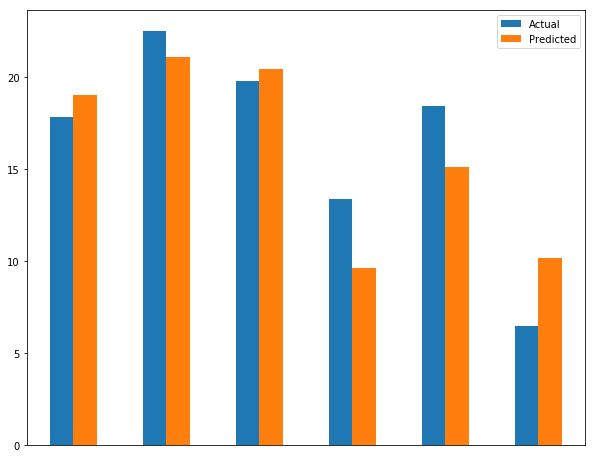

In [8]:
df_lr_pred[['Actual', 'Predicted']].plot(kind='bar', figsize=(10, 8))
ax = plt.axes()
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
plt.show()

The results show a mean cross validation R-squared score of .74, which means that 74% of the variance of the data can be explained by the linear regression model built. This is an average across all the 10-folds of cross-validation. 

Moreover, after predicting the Y-values (diversion rates) from the test X data, we can compare that against the actual diversion rates held out in the y_test set to determine how closely the predictions matched the actual data. For this, we use the metric root mean squared error, which measures the average difference between the predicted rates and actual rates. 

Both these metrics are fairly strong, but ideally we'd like a root mean squared error (RMSE) closer to 0 and an R-squared score closer to 1.0. As such, we will evaluate the data through 3 more models in order to determine the best model that can predict diversion rate from the features available. 

The next model we'll attempt is a variation of linear regression using lasso regularization, which combines variable selection and regression to determine which variables are relevant by determining their coefficients and shrinking any that don't improve the model to 0. We will reset the X and Y train/test arrays to include all 16 variables as we will include all in the next 3 models.

In [9]:
#Reset train test split X and Y arrays with all 16 variables
X_train, X_test, y_train, y_test = train_test_split(features , target.iloc[:, 0], test_size = 0.1, random_state = 0)

Best alpha using built-in LassoCV: 1.199457
Best score using built-in LassoCV: 0.797443
Lasso picked 8 variables and eliminated the other 8 variables


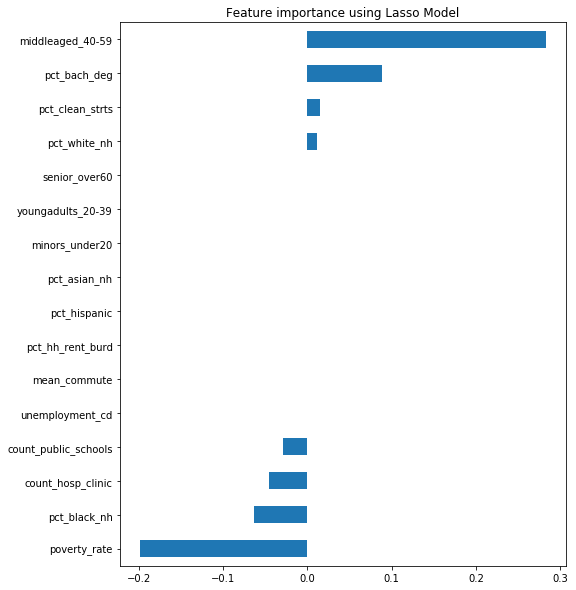

In [10]:
#Embedded Method using Lasso Regularization

reg = LassoCV()
reg.fit(features, target.iloc[:, 0])
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(features, target.iloc[:, 0]))
coef = pd.Series(reg.coef_, index = features.columns)
y_pred2 = reg.predict(X_test)
rmse_ls = np.sqrt(mean_squared_error(y_test, y_pred2))

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

As seen above, the lasso regularization yielded a fairly high R-squared score of .80 and also helped determine the feature importances of each of the variables, leaving 8 variables and eliminating the other 8 through shrinkage. Interesingly the highest postive and negative scored variables were percent middle aged and poverty rate

Below we'll plot the coefficients of the RFE regression model to see how the results compare

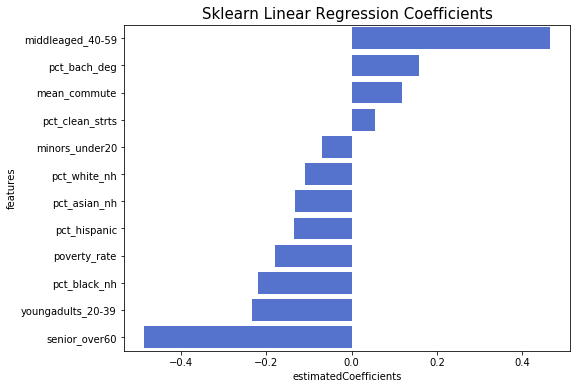

(             features  estimatedCoefficients
 0    middleaged_40-59               0.465265
 1        pct_bach_deg               0.158944
 2        mean_commute               0.117967
 3     pct_clean_strts               0.055974
 4      minors_under20              -0.069014
 5        pct_white_nh              -0.108791
 6        pct_asian_nh              -0.131884
 7        pct_hispanic              -0.135596
 8        poverty_rate              -0.179284
 9        pct_black_nh              -0.218886
 10  youngadults_20-39              -0.234190
 11      senior_over60              -0.485886, None)

In [12]:
# Plot the coefficients
lr_imp = pd.DataFrame({'features': features_lr.columns, 'estimatedCoefficients': lr.coef_})[['features', 'estimatedCoefficients']].sort_values('estimatedCoefficients', ascending = False).reset_index(drop = True)
sns.barplot(x = 'estimatedCoefficients', y = 'features', data = lr_imp, orient = 'h', color = 'royalblue').set_title('Sklearn Linear Regression Coefficients', fontsize = 15)
matplotlib.rcParams['figure.figsize'] = (8, 6)
lr_imp, plt.show()

The next technique we will evaluate is XGBOOST, which uses the technique of gradient boosting to build an ensemble model of weaker predictive models that aggregate by using the results to improve the next model iteratively. Boosting through XGBoost can be done by using decision tree regression or linear regression.fsfs

One difference between the XGBOOST regressor compared to a simple linear regressor is that we have to input hyperparameters, such as using a linear or tree as booster and the number of estimators to evaluate. This can be tuned using gridsearch as shown below. We first define the parameter grid of the options for each hyperparameter we want to test, instatiate the gridsearch object with our model and parameter grid, and then fit the model to our training data. Moreover, we will use cross-validation to test different breakdowns of training data used for holdout and test. 

In [13]:
%%capture
param_grid_xg = {'booster': ['gblinear', 'gbtree'], 'n_estimators': range(1, 20)} 
xg_grid = xgb.XGBRegressor()
xg_gridsearch = GridSearchCV(estimator= xg_grid, param_grid= param_grid_xg, cv=10)
xg_gridsearch.fit(X_train, y_train)

In [14]:
xg_gridsearch.best_score_, xg_gridsearch.best_estimator_

(0.45929551694499005,
 XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0,
        importance_type='gain', learning_rate=0.1, max_delta_step=0,
        max_depth=3, min_child_weight=1, missing=None, n_estimators=19,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1))

After running the grid search, we've determined the optimal booster to be 'gblinear' and the optimal number of estimators to be 19 as they produce the best score. We can proceed to use this model to predict the rates by plugging in the test data and evaluating the RMSE and R-squared thereafter, as shown below

In [15]:
##DELETE THIS?
xgb = xgb.XGBRegressor(booster='gblinear', n_estimators=19)
xgb.fit(X_train, y_train)

[23:29:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/varunraja/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=19,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [16]:
y_pred3 = xg_gridsearch.predict(X_test)
rmse_xg = np.sqrt(mean_squared_error(y_test, y_pred3))

print("R-Squared Score:", xg_gridsearch.score(X_test, y_test))

R-Squared Score: 0.690539105349


After predicting the diversion rates and comparing against the test data, we discover a RMSE of 2.90 which is higher than the standard linear regression completed previously, along with a score of .69 which is also lower than the linear model score of .74. This suggests that the model is weaker than the simple linear regression. While boosting is generally stronger than most models than run one iteration, it is possible that with limited data size it's accuracy potential is limited.

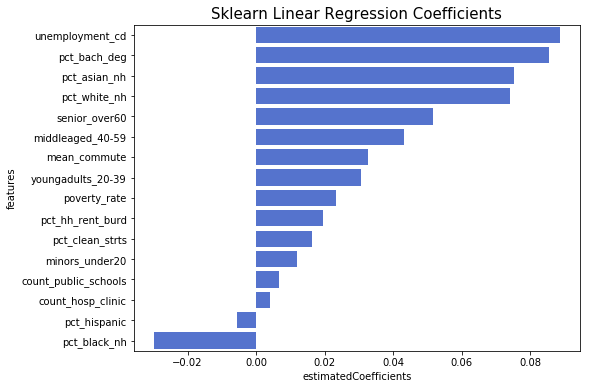

(                features  estimatedCoefficients
 0        unemployment_cd               0.088694
 1           pct_bach_deg               0.085474
 2           pct_asian_nh               0.075250
 3           pct_white_nh               0.074007
 4          senior_over60               0.051676
 5       middleaged_40-59               0.043274
 6           mean_commute               0.032671
 7      youngadults_20-39               0.030674
 8           poverty_rate               0.023484
 9       pct_hh_rent_burd               0.019700
 10       pct_clean_strts               0.016277
 11        minors_under20               0.012112
 12  count_public_schools               0.006768
 13     count_hosp_clinic               0.004188
 14          pct_hispanic              -0.005444
 15          pct_black_nh              -0.029785, None)

In [17]:
# The coefficients
xgb_imp = pd.DataFrame({'features': features.columns, 'estimatedCoefficients': xgb.coef_})[['features', 'estimatedCoefficients']].sort_values('estimatedCoefficients', ascending = False).reset_index(drop = True)
sns.barplot(x = 'estimatedCoefficients', y = 'features', data = xgb_imp, orient = 'h', color = 'royalblue').set_title('Sklearn Linear Regression Coefficients', fontsize = 15)
xgb_imp, plt.show()

Lastly, we will attempt to use a random forest regressor, or a ensemble model consisting of multiple decision trees that are run in parallel and whose results are aggregated and averaged to increase the accuracy of the predictor. 

Since the random forest regressor also includes hyperparameter inputs including max depth or branches and number of estimators, we will use grid search and cross validation similar to what was run for XGBoost. We do again by defining a parameter grid of all parameter values to be tested for each input and fit the model to our training data.

In [18]:
param_grid = {'max_depth': range(5, 50, 5), 'n_estimators': range(1, 20)} 
rand_forest_grid = RandomForestRegressor(random_state=0)
rf_gridsearch = GridSearchCV(estimator=rand_forest_grid, param_grid=param_grid, cv=5)
rf_gridsearch.fit(X_train, y_train)
rf_gridsearch.best_score_, rf_gridsearch.best_estimator_

(0.56156025250316199,
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))

As we can see, the gridsearch results against the random forest regressor show that a model with the specified parameters of max depth 25 and 6 estimators yields the best score. We can now fit this against the test data to predict the diversion rates and find the RMSE and score of the best random forest model. 

In [19]:
y_pred4 = rf_gridsearch.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred4))
print("Root Mean Squared Error (RMSE):", rmse_rf)
print("R-Squared Score:", rf_gridsearch.score(X_test, y_test))

Root Mean Squared Error (RMSE): 1.96603121397
R-Squared Score: 0.85779815599


After predicting the diversion rates and comparing against the test data, we discover a RMSE of 1.97 along with a score of .86, both of which beat out the linear regression, lasso, and XGBoost models. This suggests that this random forest may be stronger in comparison in terms of determining the diversion rates based on the available data. The R-squared score of .86 suggests that 86 percent of the recycling data can be represented by the model.

Now that we've built and tested each of our models, we will take a look once again at the results of each to compare.

In [20]:
#Compare models through RMSE and R^2 scores
print("Root Mean Squared Error - Linear Regression:", rmse_lr)
print("Root Mean Squared Error - Lasso Regression:", rmse_ls)
print("Root Mean Squared Error - XGBoost:", rmse_xg)
print("Root Mean Squared Error - Random Forest:", rmse_rf)

Root Mean Squared Error - Linear Regression: 2.65969826231
Root Mean Squared Error - Lasso Regression: 1.55190305297
Root Mean Squared Error - XGBoost: 2.90028504349
Root Mean Squared Error - Random Forest: 1.96603121397


In [21]:
print("R-Squared Score - Linear Regression:", lr_score)
print("R-Squared Score - Lasso Regression:", reg.score(features, target.iloc[:, 0]))
print("R-Squared Score - XGBoost:", xg_gridsearch.score(X_test, y_test))
print("R-Squared Score - Random Forest:", rf_gridsearch.score(X_test, y_test))

R-Squared Score - Linear Regression: 0.739750951785
R-Squared Score - Lasso Regression: 0.797443091589
R-Squared Score - XGBoost: 0.690539105349
R-Squared Score - Random Forest: 0.85779815599


Upon reviewing the root mean squared error of each model, it looks like the Lasso Regression model delivers the lowest value, meaning it is the highest performing since RMSE measures the difference between the predicted Y value and actual values. However when comparing the R-squared scores of each it looks like the Random Forest regressor performs the best with a score of .813, just edging out the Lasso score .797. A higher R-squared score suggests that a higher percentage of the variance of the target Y variable (in this case diversion rate) can be explained by the model. 

Both metrics are useful for gauging the effectiveness of a model, but given the main thing we'd like to explore is the significance of particular demographic features on rates rather than predictability, having a higher R-squared is more relevant. Moreover, RMSE can be less accurate as it can be greatly influenced by outliers which have a greater impact in limited dataset sizes. 

As such, we will choose the Random Forest model as the best representative in highlighting which combination of features impact recycling rates. We can further explore this by determining the feature importance of each variable in influencing the regression model. We will explore and plot this below by using the model attribute 'feature_importances' to create a dataframe of importance level and plotting in a bar chart.

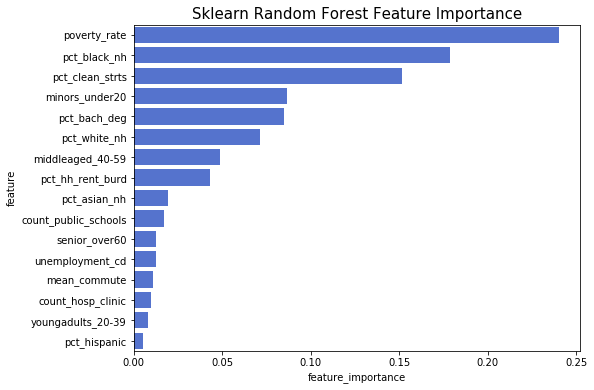

In [22]:
rand_forest = RandomForestRegressor(random_state=0, max_depth=10, n_estimators=11)
rand_forest.fit(X_train, y_train)

df_feature_importance = pd.DataFrame({'feature': X_train.columns,
                       'feature_importance': rand_forest.feature_importances_}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        
sns.barplot(x = 'feature_importance', y = 'feature', data = df_feature_importance, orient = 'h', color = 'royalblue').set_title('Sklearn Random Forest Feature Importance', fontsize = 15)
        
plt.show()